# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow 
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

In [3]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## CUDA

In [4]:
gpus = tensorflow.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
            
        logical_gpus = tensorflow.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
    except RuntimeError as e:
        
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


## Data handling parameters

In [5]:
# Parameters
#
filename   = 'Data/Austin_Weather.csv'

Transformation  = False
Scaling         = 'Standard'

## Neural networks parameters

In [6]:
Lag        =   48
Horizon    =    6
#
epochs     = 2000
batch_size =   4

# Data handling

## Import data


In [7]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.01 seconds


,Date,Temperature [Fahrenheit],DewPoint [Fahrenheit],Humidity [%],SeaLevelPressure [inches],Wind [mph],DayOfWeek,Month
0,2013-12-21,60,49.0,75.0,29.68,4.0,5,12
1,2013-12-22,48,36.0,68.0,30.13,6.0,6,12
2,2013-12-23,45,27.0,52.0,30.49,3.0,0,12


## Preprocess data

### Set index

In [8]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)

df.head(3)

,Temperature [Fahrenheit],DewPoint [Fahrenheit],Humidity [%],SeaLevelPressure [inches],Wind [mph],DayOfWeek,Month
Date,,,,,,,
2013-12-21,60,49.0,75.0,29.68,4.0,5,12
2013-12-22,48,36.0,68.0,30.13,6.0,6,12
2013-12-23,45,27.0,52.0,30.49,3.0,0,12


In [9]:
# Set target Series
#
targetSeries = 'Temperature [Fahrenheit]'

### Split Training/Testing

In [10]:
idx = int( df.shape[0] * 0.9 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

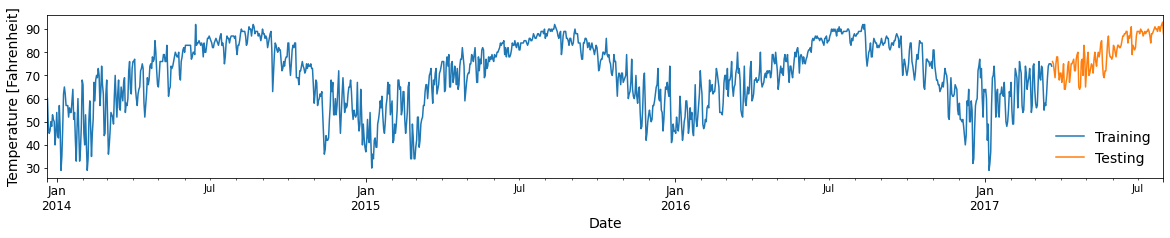

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[targetSeries].plot(ax=ax, color='tab:blue' )
df_test[targetSeries].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [12]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [13]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
        
    df_train = np.log( df_train )
    df_test  = np.log( df_test  )   
    
else:
    print('[INFO] No data transformation applied.')    

[INFO] No data transformation applied.


In [14]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()
          
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()
    

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Scaling 
#
for feature in df_train.columns:
    if (feature == targetSeries): continue

    # Performing Scaling - for each feature
    df_train[feature] = scaler.fit_transform( df_train[feature].to_numpy().reshape(-1,1) )
    df_test[feature]  = scaler.transform( df_test[feature].to_numpy().reshape(-1,1) )

df_train[targetSeries] = scaler.fit_transform( df_train[targetSeries].to_numpy().reshape(-1,1) )
df_test[targetSeries]  = scaler.transform( df_test[targetSeries].to_numpy().reshape(-1,1) )


[INFO] Scaling: Standard


## Create Training/Testing data

In [15]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )

In [16]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = 3)

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries)

print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 127/127 [00:00<00:00, 43662.02it/s]

Training instances:      378
Testing instances:       127


# Forecasting model: NBeats

## Setup model

In [17]:
from utils.NBeats_Keras import NBeatsNet

model = NBeatsNet(input_dim          = trainX.shape[2],
                  stack_types        = (NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  forecast_length    = Horizon,
                  backcast_length    = Lag, 
                  hidden_layer_units = 64)

## Training parameters

In [18]:
# Define metrics
#
metrics = [
            MeanAbsolutePercentageError(name = "MAPE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]

model.compile(loss = 'mse', optimizer = Adam(learning_rate = 1.e-4), metrics = metrics)

In [19]:
# Checkpoint
#
checkpoint = ModelCheckpoint("models/NBeats_Keras.hdf5", 
                              monitor        = 'val_RMSE', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_RMSE', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_RMSE', 
                                   factor      = 0.5,
                                   patience    = 5)

## Training process

In [20]:
# Start clock
#
start = time.time()


score = model.fit(trainX, trainY, 
                  epochs          = 200, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  verbose         = 1, 
                  validation_data = (testX, testY))


# Terminate clock
#
stop = time.time()
print('[INFO] Time %.2f' % (stop - start))

Epoch 1/200
95/95 [==============================] - 5s 49ms/step - loss: 0.9335 - MAPE: 161.7994 - RMSE: 0.9662 - val_loss: 0.5983 - val_MAPE: 108.9684 - val_RMSE: 0.7735 - lr: 1.0000e-04
Epoch 2/200
95/95 [==============================] - 3s 31ms/step - loss: 0.5369 - MAPE: 130.9234 - RMSE: 0.7327 - val_loss: 0.3667 - val_MAPE: 103.4584 - val_RMSE: 0.6056 - lr: 1.0000e-04
Epoch 3/200
95/95 [==============================] - 3s 31ms/step - loss: 0.3668 - MAPE: 127.1990 - RMSE: 0.6056 - val_loss: 0.2579 - val_MAPE: 120.3844 - val_RMSE: 0.5078 - lr: 1.0000e-04
Epoch 4/200
95/95 [==============================] - 3s 32ms/step - loss: 0.2926 - MAPE: 131.7774 - RMSE: 0.5409 - val_loss: 0.1216 - val_MAPE: 102.8264 - val_RMSE: 0.3487 - lr: 1.0000e-04
Epoch 5/200
95/95 [==============================] - 3s 30ms/step - loss: 0.2700 - MAPE: 130.0287 - RMSE: 0.5196 - val_loss: 0.2012 - val_MAPE: 123.5399 - val_RMSE: 0.4485 - lr: 1.0000e-04
Epoch 6/200
95/95 [==============================] - 3s

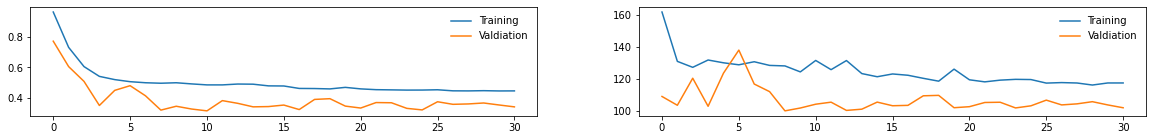

In [21]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 2) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'])
ax[0].plot( score.history['val_RMSE'])
ax[0].legend(['Training', 'Valdiation'], frameon = False)


# Plot RMSE
#
ax[1].plot( score.history['MAPE'])
ax[1].plot( score.history['val_MAPE'])
ax[1].legend(['Training', 'Valdiation'], frameon = False)

## Load optimized model

In [22]:
# Load the best model
#
model.load_weights('models/NBeats_Keras.hdf5')

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [23]:
# Get predictions
#
pred = model.predict( testX )

### Calculate Performance on Testing set - Prediction visualization


In [24]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
    print('Horizon: ', i)
    print('> MAE:   ', MAE)
    print('> RMSE:  ', RMSE)
    print('> SMAPE: ', SMAPE)
    print('> R2:    ', R2)
    print()

[INFO] Feature:  Temperature [Fahrenheit]
------------------------------------------------
Horizon:  0
> MAE:    3.6284797247939222
> RMSE:   4.366531661717267
> SMAPE:  4.688122904753333
> R2:     0.6704101035057153

Horizon:  1
> MAE:    3.728139862300843
> RMSE:   4.444353480800449
> SMAPE:  4.827504887909764
> R2:     0.6619857767797686

Horizon:  2
> MAE:    3.7522046547236405
> RMSE:   4.4679465143163135
> SMAPE:  4.8435467059632265
> R2:     0.6631113831696593

Horizon:  3
> MAE:    3.6483648104930486
> RMSE:   4.342197257666263
> SMAPE:  4.683164474323007
> R2:     0.6853372372322852

Horizon:  4
> MAE:    3.546873678372601
> RMSE:   4.317434804498919
> SMAPE:  4.554448763743176
> R2:     0.6907436754194968

Horizon:  5
> MAE:    3.798908233642578
> RMSE:   4.71806009265813
> SMAPE:  4.89790241005825
> R2:     0.6323003099548095



## Visualization

[INFO] Feature:  Temperature [Fahrenheit]
------------------------------------------------


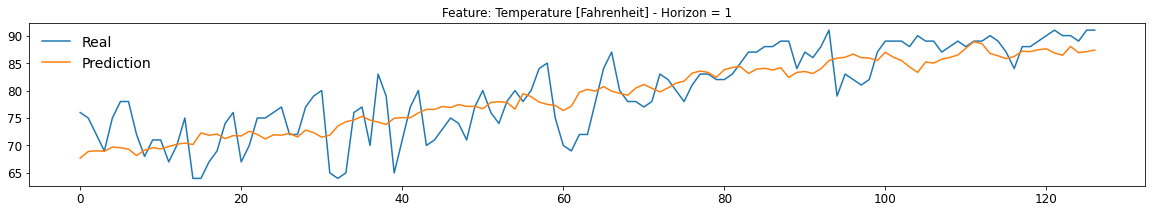

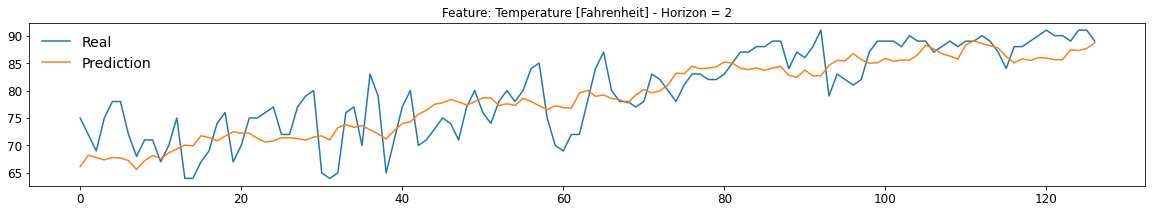

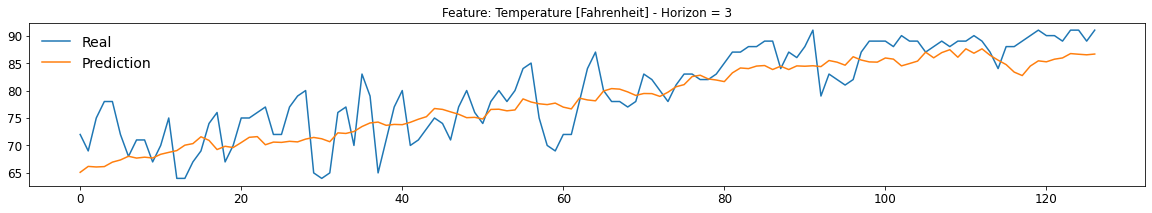

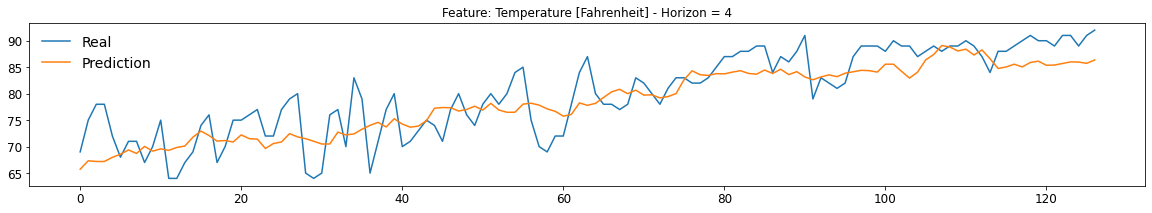

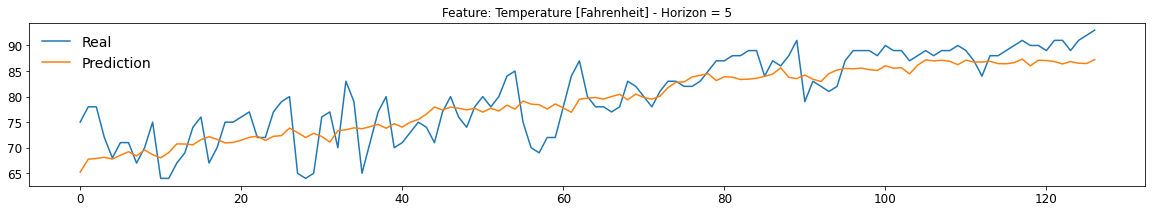

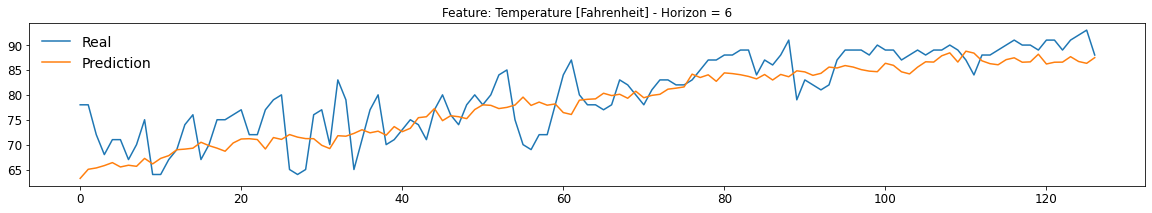

In [25]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )
            
            
    # Plot Real & Predicted values
    #
    Prices[:200].plot( figsize = (20, 3) )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

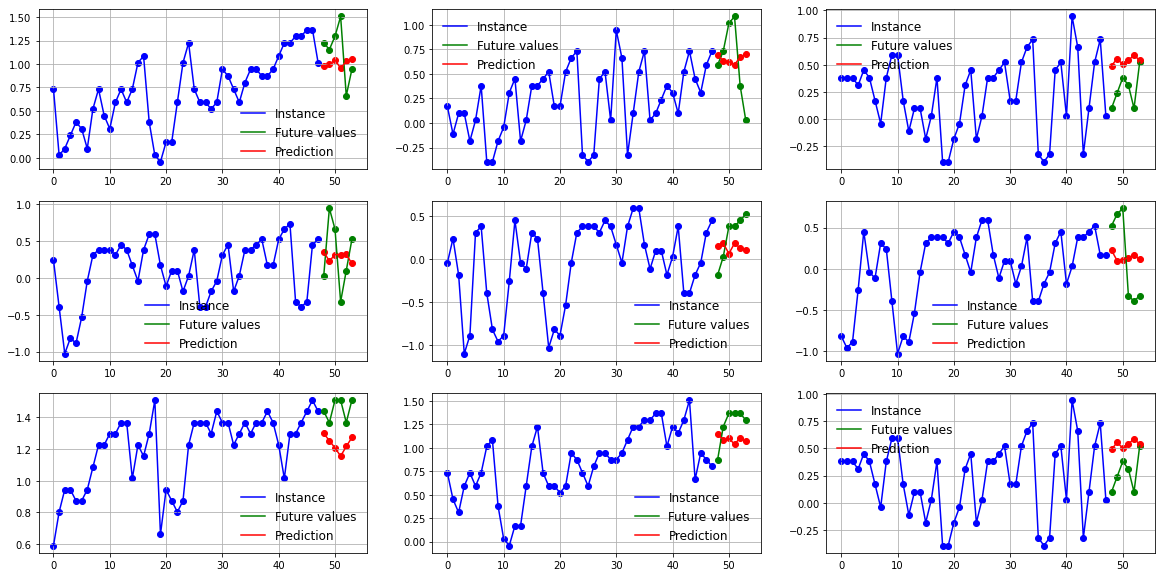

In [45]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 10) )
RandomInstances = [random.randint(1,testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, Lag), testX[i, :, 0], color='b')
    plot_scatter(range(Lag, Lag + Horizon), testY[i], color='g')
    plot_scatter(range(Lag, Lag + Horizon), pred[i], color='r')

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()